In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os
import dotenv
import os
import tifffile
import deepmars.utils
import deepmars.features.template_match_target as tmt
import cartopy.crs as ccrs
import seaborn as sns

In [2]:
project_dir = os.path.join(os.getcwd(), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')
found = dotenv.load_dotenv(dotenv_path)

In [3]:
dims=[53347,106694]
_overlap=0.25

In [4]:
# number at each image extent
np.array([(p,(1+dims[0]//(p*(1-_overlap)))*(1+dims[1]//(p*(1-_overlap)))) for p in 2**np.arange(8,16)]).astype(int).cumsum(axis=0)

array([[   256, 154568],
       [   768, 193210],
       [  1792, 202940],
       [  3840, 205390],
       [  7936, 206020],
       [ 16128, 206182],
       [ 32512, 206227],
       [ 65280, 206242]])

In [5]:
import itertools
def uniform_yield(start,amt,dims,res_low,res_high,overlap=_overlap):
    def yy(res, dims,edge):
        for ix,iy in itertools.product(np.arange(0,dims[0],int(res*edge)),
                                       np.arange(0,dims[1],int(res*edge))):
            yield (ix,iy)
    res = res_low
    flag=True
    edge = 1 - overlap
    counter=0
    i=0
    mystart=0
    total_counter=0
    while flag:      
        for counter,vals in enumerate(yy(res,dims,edge)):
            total_counter+=1
            if total_counter > start and total_counter <= start+amt:
                yield (i,vals[0],vals[1],res)
                i=i+1
            else:
                pass #throw away
            if total_counter >= start+amt:
                return
        if res>res_high:
            flag=False
        else:
            res=res*2

def randomized(amt, istart,dims, rawlen_min, rawlen_max):
    def random_sampler():
            return int(10**np.random.uniform(np.log10(rawlen_min), np.log10(rawlen_max)))

    for i in range(amt):
        # Determine image size to crop.
        rawlen = random_sampler()
        if rawlen > dims[1]:
            rawlen = dims[1]
            yc = 0
            xc = np.random.randint(0, dims[0] - rawlen)
        else:
            xc = np.random.randint(0, dims[0] - rawlen)
            yc = np.random.randint(0, dims[1] - rawlen)
        yield (i, xc, yc, rawlen)

In [14]:
sys=np.array(list((uniform_yield(0,2000000,dims[::-1] ,2**8,2**15))))
l=sys.shape[0]
ran=np.array(list((randomized(l,0,dims[::-1] ,2**8,2**13))))

In [15]:
#number of images
print("Number of images: ",sys.shape[0])
res_sys = sys[:,-1]
res_ran = ran[:,-1]

Number of images:  206248


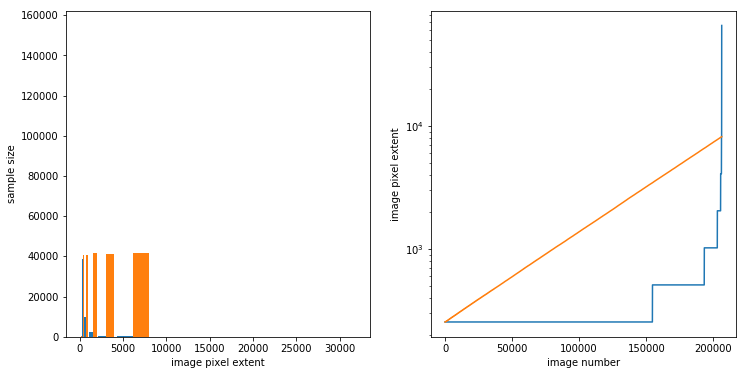

In [16]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.hist([res_sys,res_ran],bins=(1+2**(np.arange(16))),rwidth=0.9)
plt.xlabel("image pixel extent")
plt.ylabel("sample size")
plt.subplot(122)
plt.plot(sorted(res_sys))
plt.plot(sorted(res_ran))
plt.xlabel("image number")
plt.ylabel("image pixel extent")
plt.yscale('log')
plt.show()

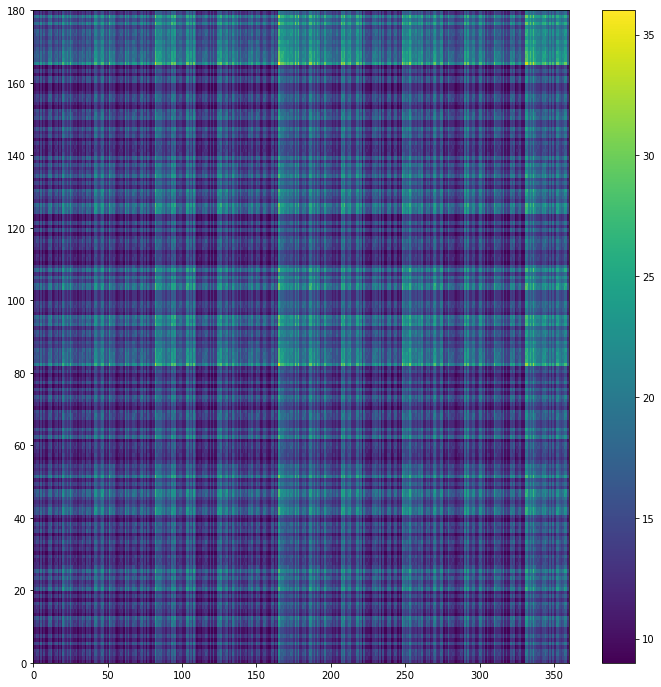

In [17]:
fig = plt.figure(figsize=(12,12))
ax=fig.gca()

lres=0
res=10**(-lres)

cc = sns.color_palette("husl", 8)
output=np.zeros((360//res,180//res))
offset=np.array([output.shape[0]//(2*res),output.shape[0]//(2*res),output.shape[1]//(2*res),output.shape[1]//(2*res)])
res=[]
res2=[]
pxs=[]
import glob
from tqdm import tqdm, tqdm_notebook
for e in tqdm_notebook(sys):
    xl,xh,yl,yh = np.array([e[1]*360/dims[1],
                            (e[1]+e[3])*360/dims[1],
                            e[2]*180/dims[0],
                            (e[2]+e[3])*180/dims[0]]).astype(int)
    output[xl:xh,yl:yh]+=1
plt.pcolormesh(output.T)
plt.colorbar()
plt.show()


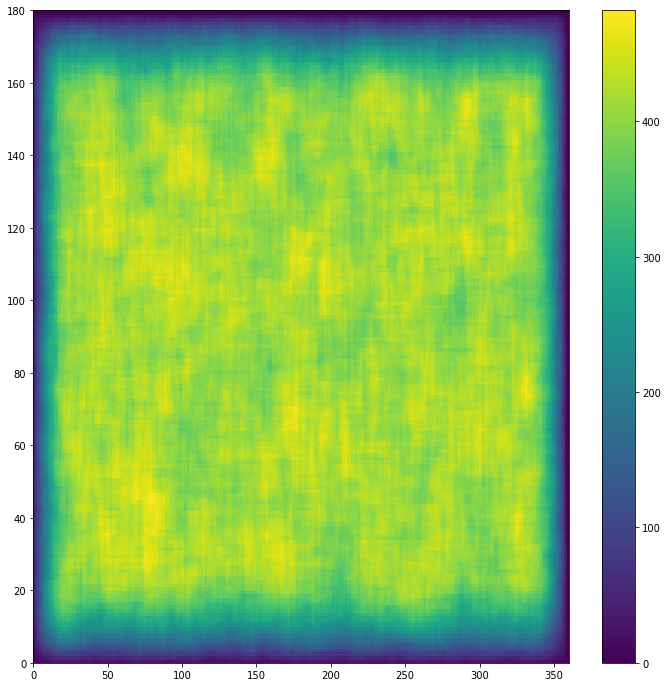

In [18]:
fig = plt.figure(figsize=(12,12))
ax=fig.gca()

lres=0
res=10**(-lres)

cc = sns.color_palette("husl", 8)
output=np.zeros((360//res,180//res))
offset=np.array([output.shape[0]//(2*res),output.shape[0]//(2*res),output.shape[1]//(2*res),output.shape[1]//(2*res)])
res=[]
res2=[]
pxs=[]
import glob
from tqdm import tqdm, tqdm_notebook
for e in tqdm_notebook(ran):
    xl,xh,yl,yh = np.array([e[1]*360/dims[1],
                            (e[1]+e[3])*360/dims[1],
                            e[2]*180/dims[0],
                            (e[2]+e[3])*180/dims[0]]).astype(int)
    output[xl:xh,yl:yh]+=1
plt.pcolormesh(output.T)
plt.colorbar()
plt.show()
